## 线性回归的从零开始实现

- 我们将从零开始实现整个方法， 包括数据流水线、模型、损失函数和小批量随机梯度下降优化器)。 虽然现代的深度学习框架几乎可以自动化地进行所有这些工作，但从零开始实现可以确保我们真正知道自己在做什么。

In [2]:
# 导入工具包
%matplotlib inline 
import random # 随机初始化权重 随机梯度下降
import torch
from d2l import torch as d2l

## 生成数据集

- 为了简单起见，根据带有噪声的线性模型构造一个人造数据集   

- 我们的任务是使用这个有限样本的数据集来恢复这个模型的参数。 我们将使用低维数据，这样可以很容易地将其可视化。    
   
- 我们使用线性模型参数 𝐰=[2,−3.4]⊤、 𝑏=4.2  和噪声项 𝜖 生成数据集及其标签：𝐲=𝐗𝐰+𝑏+𝜖

In [4]:
def synthetic_data(w, b, num_examples):  # num_examples 样本数
    """生成 y = Xw + b + 噪声"""
    X = torch.normal(0, 1, (num_examples, len(w))) # 均值为 0 ，方差为 1 的随机数，n个样本，列数就是 w的长度
    y = torch.matmul(X,w) + b # matmul 矩阵乘法
    y += torch.normal(0, 0.01, y.shape) # 加入噪音，均值为0，方差为0.01，长度和y一样
    return X, y.reshape((-1, 1)) # 把Y做成列向量返回

true_w = torch.tensor([2, -3.4])  # 真实的w
true_b = 4.2                      # 真实的b
features, labels = synthetic_data(true_w, true_b, 1000)

- features中的每一行都包含一个二维数据样本， labels中的每一行都包含一维标签值（一个标量）

In [18]:
features, features[0]

(tensor([[-0.2598, -0.9330],
         [-0.2425,  0.5376],
         [ 0.3444,  0.0557],
         ...,
         [-2.2246,  0.2447],
         [ 0.4472,  1.0916],
         [-0.7625,  0.7377]]),
 tensor([-0.2598, -0.9330]))

In [19]:
labels, labels[0]

(tensor([[ 6.8439e+00],
         [ 1.8805e+00],
         [ 4.6952e+00],
         [ 3.6738e+00],
         [ 1.0982e+00],
         [-2.8445e+00],
         [ 7.7393e+00],
         [ 3.3673e+00],
         [ 4.4784e+00],
         [ 6.4732e+00],
         [ 4.8232e+00],
         [ 3.6682e-01],
         [ 2.2531e+00],
         [ 1.0658e+00],
         [-3.2144e-01],
         [ 1.1144e+01],
         [ 5.8276e+00],
         [ 7.2708e+00],
         [ 1.2754e+01],
         [ 1.0864e+01],
         [ 2.9561e+00],
         [ 8.5075e+00],
         [-1.8914e+00],
         [ 6.5027e+00],
         [ 3.1600e+00],
         [ 5.1123e+00],
         [ 4.3065e+00],
         [ 5.8571e+00],
         [ 9.8436e+00],
         [ 5.8808e-01],
         [ 7.4957e+00],
         [ 6.5145e+00],
         [ 3.0450e+00],
         [-6.3599e-01],
         [ 3.9603e+00],
         [ 8.6242e+00],
         [ 9.4848e+00],
         [-9.6722e-01],
         [ 3.8345e+00],
         [ 5.4247e+00],
         [ 6.8675e+00],
         [ 3.675

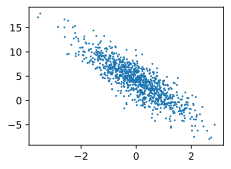

In [20]:
d2l.set_figsize()
# detach 是因为pytroch需要由此转到numpy
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

### 读取数据集   

- 回想一下，训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。
- 由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数， 该函数能打乱数据集中的样本并以小批量方式获取数据。

- 定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量 每个小批量包含一组特征和标签。

In [24]:
def data_iter(batch_size, features, labels):
    num_exmaples = len(features)
    indices = list(range(num_exmaples))  # 每个样本的index
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_exmaples, batch_size):
        # 防止最后超出样本数，加个min
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_exmaples)])
        # yield 生成器，迭代return 直到最后
        yield features[batch_indices], labels[batch_indices]
        
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 2.0784,  0.7596],
        [ 0.6345, -1.0976],
        [-0.5689, -0.2391],
        [ 0.0802,  0.7459],
        [ 0.0806,  1.3857],
        [-1.6205,  0.0857],
        [-1.7857, -1.2127],
        [-0.7377,  0.7366],
        [ 0.6660, -0.1080],
        [-1.1161,  1.3437]]) 
 tensor([[ 5.7651],
        [ 9.2091],
        [ 3.8752],
        [ 1.8480],
        [-0.3643],
        [ 0.6542],
        [ 4.7517],
        [ 0.2103],
        [ 5.8979],
        [-2.6077]])


### 初始化模型参数

- 在我们开始用小批量随机梯度下降优化我们的模型参数之前

In [25]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)  # 需要计算梯度
b = torch.zeros(1, requires_grad=True)

### 定义模型

In [26]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

### 定义损失函数

In [27]:
def squared_loss(y_hat, y): 
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2  # 没有做均值

### 定义优化算法

In [28]:
def sgd(params, lr, batch_size):  # params 所有参数
    """小批量随机梯度下降"""
    with torch.no_grad():        # 更新时不计算梯度
        for param in params:
            param -= lr * param.grad / batch_size  # 损失函数没有均值，这里需要除batchsize
            param.grad.zero_()   # pytorch不支持自动清零，需要手动

### 训练过程

In [29]:
# 定义超参数
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [30]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward() # l 是向量
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数，最后一个批量可能不太正确
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.045988
epoch 2, loss 0.000182
epoch 3, loss 0.000051


### 比较真实参数和通过训练学到的参数来评估训练的成功程度

In [31]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0001, -0.0009], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)
